# Recurrent Neural Networks
The following Recurrent Neural Networks (RNN) will be used for musical genre classification. This is because the task of classify all the new music that is released nowadays it is impossible to be done by a human being.

## Initialization

### Libraries

In [1]:
# Import general purpose python libraries
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import LSTM, Bidirectional, Dense, Attention,Input, Dropout, TimeDistributed, Flatten
from tensorflow.keras.models import Model, Sequential
from keras.optimizers import SGD, Adam
from keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

# Import function to plot the results
!pip install seaborn
import plots

### Data Configuration Parameters
Configuration variables related to the data

In [2]:
# Randomize the initial network weights
random_seed = True

# Paths to where training, testing, and validation images are
database_dir = 'dataset'
train_dir = f'{database_dir}/training/spectrogram'
val_dir = f'{database_dir}/val/spectrogram'
test_dir = f'{database_dir}/test/spectrogram'

# Directory where to store weights of the model and results
root_dir = "results"
# Create root directory for results if it does not exist
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

# Input dimension (number of subjects in our problem)
num_classes = 6

# Name of each gesture of the database
CLASSES = [x for x in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, x))]
print(f'The classess to classify are: {CLASSES}')

# Parameters that characterise the spectrogram
img_height = 369
img_width = 496
img_channels = 1
color_mode = 'grayscale'

The classess to classify are: ['Alternative', 'Classical', 'Dance', 'Pop', 'Rock', 'Techno']


### Configuration Training Parameters

In [3]:
# Parameters that configures the training process
batch_size = 8  # Batch size
epochs = 15  # Number of epochs
initial_lr = 1e-4   # Learning rate
seed = 42  # Random number
num_neurons = 64
num_layers = 1
modelRNN = 'LSTM'  # BiLSTM or LSTM
version = f'L_{num_layers}_N_{num_neurons}_BS{batch_size}_E{epochs}_LR{initial_lr}'
experiment_dir = f'{root_dir}/{modelRNN}'

# Create experiment directory if it does not exist
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

### Loading of training, validation and test datasets of images
1.   Training dataset
2.   Validation dataset
3.   Test dataset

In [4]:
# 1. Generate train dataset (ds) from directory of samples
train_ds = image_dataset_from_directory(directory=train_dir,
                                        label_mode = 'categorical',
                                        class_names=CLASSES,
                                        batch_size=batch_size,
                                        color_mode=color_mode,
                                        image_size=(img_height, img_width), shuffle=True)

# 2. Generate validation dataset (ds) from directory of samples
val_ds  = image_dataset_from_directory(directory=val_dir,
                                       label_mode = 'categorical',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_height, img_width), shuffle=True)

# 3. Generate test dataset (ds) from directory of samples
test_ds = image_dataset_from_directory(directory=test_dir,
                                       label_mode = 'categorical',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_height, img_width),
                                       shuffle = False)

Found 1186 files belonging to 6 classes.
Found 204 files belonging to 6 classes.
Found 204 files belonging to 6 classes.


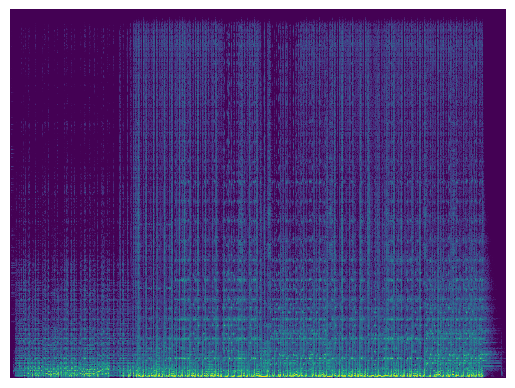

(369, 496, 1)


In [5]:
# Example of an dataset's images
for images, labels in train_ds.take(1):
    # Obtén la primera imagen del lote
    img = images[0]

    # Muestra la imagen utilizando matplotlib
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis('off')  # Desactiva los ejes
    plt.show()
    print(img.numpy().shape)

# Training process
#### Available Models: LSTM & BiLSTM

### Long Short-Term Memory (LSTM)

In [6]:
def lstm(height, width, out_dim, neurons):
    # Sequential Model
    model_lstm = Sequential()
    model_lstm.add(LSTM(neurons, input_shape=(height, width), activation='tanh', return_sequences=True))
    model_lstm.add(Dropout(0.2))

    #model_lstm.add(LSTM(32, activation='tanh'))
    #model_lstm.add(Dropout(0.2))
    model_lstm.add(Flatten())

    model_lstm.add(Dense(32, activation='relu'))
    model_lstm.add(Dropout(0.2))

    model_lstm.add(Dense(out_dim, activation='softmax'))

    return model_lstm

### Bidirectional Long Short-Term Memory (BiLSTM)

In [7]:
def bi_lstm(height, width, out_dim, neurons):
    # Sequential Model
    model_bilstm = Sequential()
    model_bilstm.add(Bidirectional(LSTM(neurons, input_shape=(height, width), activation='tanh', return_sequences=True)))
    # model_bilstm.add(Attention(name='attention_weight'))
    model_bilstm.add(Dropout(0.2))

    #model_bilstm.add(Bidirectional(LSTM(neurons, activation='tanh')))
    #model_bilstm.add(Attention(name='attention_weight'))
    #model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Flatten())

    model_bilstm.add(Dense(64, activation='relu'))
    model_bilstm.add(Dropout(0.2))

    model_bilstm.add(Dense(out_dim, activation='softmax'))

    # Explicitly build the model
    model_bilstm.build(input_shape=(None,height, width))
    
    return model_bilstm

## Model execution

In [8]:
#Model
model = None
if modelRNN == 'LSTM':
    model = lstm(img_height, img_width, num_classes, num_neurons)
elif modelRNN == 'BiLSTM':
    model = bi_lstm(img_height, img_width, num_classes, num_neurons)
else:
    print('Wrong model selection or Model no available\n')

# Print the architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 369, 64)           143616    
                                                                 
 dropout (Dropout)           (None, 369, 64)           0         
                                                                 
 flatten (Flatten)           (None, 23616)             0         
                                                                 
 dense (Dense)               (None, 32)                755744    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 899,558
Trainable params: 899,558
Non-trai

## Set model training process
#### Configuration of several training decisions:
1. Optimizer using `Adam`
2. Model training configuration using `compile` with `categorical_crossentropy` due to the classification labeling

In [9]:
# 1. Configure optimizer
adam = Adam(learning_rate=initial_lr)

# 2. Configure training process
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])


## Train the model
1. Load parameters from previous trainings if they exist.
2. Fit the model
3. Save the weights

In [10]:
# Load pretrained model
weights_path = f"weights_{version}.h5" # Name of the file to store the weights
weights_file = Path(weights_path)
weights_load_path = f'{experiment_dir}/{weights_path}'
#if weights_load_path:
#    try:
#        model.load_weights(weights_load_path)
#        print("Loaded model from {}".format(weights_load_path))
#    except:
#        print("Impossible to find weight path. Returning untrained model")

# Fit the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

# Save weights
weights_save_path = os.path.join(experiment_dir, weights_path)
model.save_weights(weights_save_path)

Epoch 1/15
149/149 [==============================] - 6s 30ms/step - loss: 1.7849 - categorical_accuracy: 0.2209 - val_loss: 1.6671 - val_categorical_accuracy: 0.2892
Epoch 2/15
149/149 [==============================] - 4s 28ms/step - loss: 1.6390 - categorical_accuracy: 0.2934 - val_loss: 1.6495 - val_categorical_accuracy: 0.3382
Epoch 3/15
149/149 [==============================] - 4s 28ms/step - loss: 1.5728 - categorical_accuracy: 0.3339 - val_loss: 1.6237 - val_categorical_accuracy: 0.3333
Epoch 4/15
149/149 [==============================] - 4s 28ms/step - loss: 1.4956 - categorical_accuracy: 0.3558 - val_loss: 1.6407 - val_categorical_accuracy: 0.2941
Epoch 5/15
149/149 [==============================] - 4s 28ms/step - loss: 1.4758 - categorical_accuracy: 0.3988 - val_loss: 1.6771 - val_categorical_accuracy: 0.3186
Epoch 6/15
149/149 [==============================] - 4s 28ms/step - loss: 1.4193 - categorical_accuracy: 0.4005 - val_loss: 1.7076 - val_categorical_accuracy: 0.308

## Training Results
Accuracy and Loss obtained along the training process

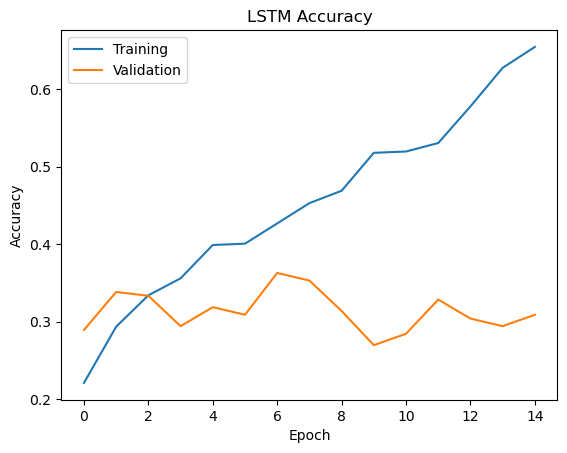

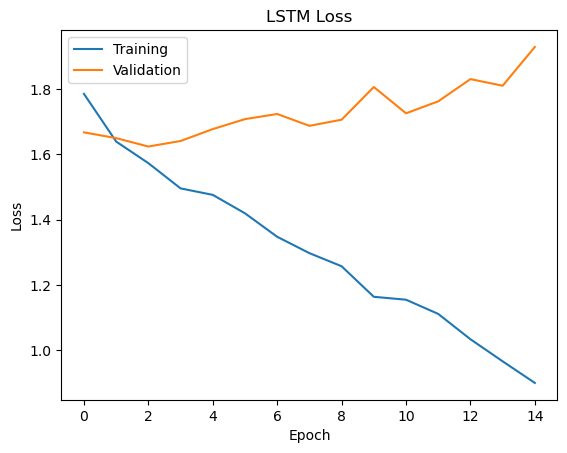

In [11]:
plots.accloss(history, modelRNN, experiment_dir, version)

# Testing
### Model Testing
1. Compute the loss function and accuracy for the test data
2. Confusion Matrix obtained from testing results

Accuracy: 29.41%
Loss: 1.92
26/26 [==============================] - 1s 21ms/step


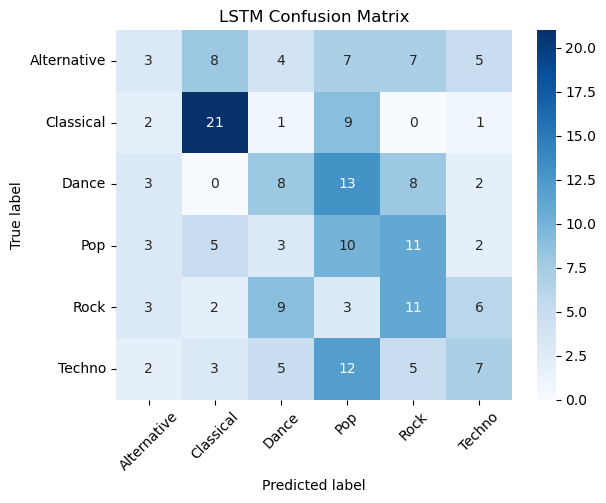

In [12]:
# Evaluate model
scores = model.evaluate(test_ds, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f" % scores[0])

# Obtain results to present the confusion matrix
prob_class = model.predict(test_ds, batch_size=batch_size)
# Classified labels
y_pred = tf.argmax(prob_class, axis=-1)
# Ground truth
y_true = tf.argmax(tf.concat([label for image, label in test_ds], axis=0), axis=1)
# Visualize confusion matrix                                           
plots.cm(y_true, y_pred, modelRNN, CLASSES, experiment_dir, version)